In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix, f1_score

import random, os, json
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, GRU, Dropout, Dense
from tensorflow.keras import backend as K
import pickle

import matplotlib.pyplot as plt

import sys

sys.path.append("../../../experiments/MDR/considering_all_features/GCNNs/step3_GCNNs/")
import utils
# sys.path.append("../../Libraries/")
# import utils

# Hyperparameters

In [2]:
# Always the same values, do not touch. 
in_dim_GCN = 1
out_dim_GCN = 1

# number of max epochs 
n_epochs = 1000

# Early stopping configuration
early_stopping_patience = 20

# Hyperparameters to be optimized (change this values)
h_dropout = [0.15,0.3, 0.45]
h_learning_rate = [1e-4, 1e-3, 1e-2, 5e-2]
h_decay = [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
h_hid_lay = [4, 8, 16, 32]
h_layers = [1, 2, 3]
seed = [42, 76, 124, 163, 192, 205, 221, 245, 293]

fc_layer = [[64, out_dim_GCN]]

# Parameters to define type of GCNN and type of output.
typeGCN = "standard_gcnn"
K = [0]

params = {# Hyperparameters
         'h_layers':h_layers, 'n_epochs':n_epochs, 'maskValue':666,
          'h_dropout': h_dropout, 'h_learning_rate': h_learning_rate, 
          'h_decay':h_decay, 'h_hid_lay': h_hid_lay, 'K':K,
          'fc_layer': fc_layer,
          # seed to set initialization hyperparameters
          'seed': seed, 
          # Type of output GCN
          'typeGCN': typeGCN,
          # Dimensions of GCN (input/output)
          'in_dim_GCN': in_dim_GCN, 'out_dim_GCN': out_dim_GCN,
          # Patiente
          'early_stopping_patience':early_stopping_patience}

# Permutation

In [3]:
features = ['AMG', 'ATF', 'CAR', 'CF1', 'CF2', 'CF3',
       'CF4', 'Falta', 'GCC', 'GLI', 'LIN', 'LIP', 'MAC', 'MON', 'NTI', 'OTR',
       'OXA', 'PAP', 'PEN', 'POL', 'QUI', 'SUL', 'TTC', 'pc_acinet',
       'pc_enterob', 'pc_enteroc', 'pc_pseud', 'pc_staph', 'pc_stenot',
       'pc_no_germ', 'isVM', 'numberOfPatients', 'numberOfPatientsMR',
       'neighbor_AMG', 'neighbor_ATF', 'neighbor_CAR', 'neighbor_CF1',
       'neighbor_CF2', 'neighbor_CF3', 'neighbor_CF4', 'neighbor_Falta',
       'neighbor_GCC', 'neighbor_GLI', 'neighbor_LIN', 'neighbor_LIP',
       'neighbor_MAC', 'neighbor_MON', 'neighbor_NTI', 'neighbor_OTR',
       'neighbor_OXA', 'neighbor_PAP', 'neighbor_PEN', 'neighbor_POL',
       'neighbor_QUI', 'neighbor_SUL', 'neighbor_TTC']
features = np.array(features)
features

array(['AMG', 'ATF', 'CAR', 'CF1', 'CF2', 'CF3', 'CF4', 'Falta', 'GCC',
       'GLI', 'LIN', 'LIP', 'MAC', 'MON', 'NTI', 'OTR', 'OXA', 'PAP',
       'PEN', 'POL', 'QUI', 'SUL', 'TTC', 'pc_acinet', 'pc_enterob',
       'pc_enteroc', 'pc_pseud', 'pc_staph', 'pc_stenot', 'pc_no_germ',
       'isVM', 'numberOfPatients', 'numberOfPatientsMR', 'neighbor_AMG',
       'neighbor_ATF', 'neighbor_CAR', 'neighbor_CF1', 'neighbor_CF2',
       'neighbor_CF3', 'neighbor_CF4', 'neighbor_Falta', 'neighbor_GCC',
       'neighbor_GLI', 'neighbor_LIN', 'neighbor_LIP', 'neighbor_MAC',
       'neighbor_MON', 'neighbor_NTI', 'neighbor_OTR', 'neighbor_OXA',
       'neighbor_PAP', 'neighbor_PEN', 'neighbor_POL', 'neighbor_QUI',
       'neighbor_SUL', 'neighbor_TTC'], dtype='<U18')

In [4]:
def permutation_time_series(X, k, hyperparameters, seed=None):
    np.random.seed(seed)
    
    # Clone the feature column you want to shuffle (P, 1) for feature k
    v_feature = X[:, k, :].clone().cpu().numpy()  # Shape (P, 1)
    
    # If there are masked values, we'll keep them as they are and shuffle the rest
    stay_length_array = (v_feature == hyperparameters["maskValue"]).sum(axis=1)  # Shape (P, 1)
    
    # Only permute the patients with the same stay length
    for i in range(v_feature.shape[0]):  # Loop over the patients
        v_feature_masked = v_feature[stay_length_array == i]
        
        # Shuffle within the patients with the same stay length
        np.random.shuffle(v_feature_masked)
        
        # Assign the shuffled values back
        v_feature[stay_length_array == i] = v_feature_masked
    
    # Ensure the reshaped v_feature is back to the correct tensor format (P, 1)
    return torch.tensor(v_feature, dtype=torch.float32).to(X.device)



from tensorflow.keras.models import load_model

def load_keras_model(filepath):
    custom_loss = utils.weighted_binary_crossentropy(hyperparameters)
    return load_model(filepath, custom_objects={'loss': custom_loss})

In [5]:
way_to_build_graph = 'dtw'
best_result_by_split = utils.loadBestHyperparameters("../../../experiments/MDR/considering_all_features/GCNNs/step3_GCNNs/"+
                                                    "hyperparameters/"+way_to_build_graph+"/GNN_th_0.975.json")

In [6]:
import torch
device = torch.device('cuda:0')


In [7]:
def load_data(norm, device, split, SG=False, numberOfTimeStep=14):
    """
    Load and preprocess the training, validation, and test data.
    
    Args:
        norm (str): Normalization type.
        device (torch.device): Device to load the data onto (CPU or GPU).
        split (str): Data split name (e.g., 'train', 'val', 'test').
        SG (bool): If True, applies special graph (SG) preprocessing. Default is False.
        numberOfTimeStep (int): Number of time steps to consider. Default is 14.
    
    Returns:
        tuple: Preprocessed tensors for training, validation, and test sets, along with their labels.
    """
    
    # Load raw data
    X_train = np.load("../../../ORIGINAL_DATA/MDR/splits_14_days/notbalanced/split_" + str(split) +
                          "/X_train_tensor_" + str(0)+ ".npy")


    X_val = np.load("../../../ORIGINAL_DATA/MDR/splits_14_days/notbalanced/split_" + str(split) +
                        "/X_val_tensor_" + str(0)+ ".npy")
    
    
    X_test = np.load("../../../ORIGINAL_DATA/MDR/splits_14_days/notbalanced/split_" + str(split) +
                        "/X_test_tensor.npy")
    

    y_train = pd.read_csv("../../../ORIGINAL_DATA/MDR/splits_14_days/notbalanced/split_" + str(split) +
                      "/y_train_" + str(0)+ ".csv",
                     index_col=0)

    y_val = pd.read_csv("../../../ORIGINAL_DATA/MDR/splits_14_days/notbalanced/split_" + str(split) +
                    "/y_val_" + str(0)+ ".csv",
                   index_col=0)
    
    y_test = pd.read_csv("../../../ORIGINAL_DATA/MDR/splits_14_days/notbalanced/split_" + str(split) + "/y_test.csv",
                            index_col=0)

       
    y_train = torch.tensor(y_train.values, dtype=torch.float32)

    y_val = torch.tensor(y_val.values, dtype=torch.float32)
    
    y_test = torch.tensor(y_test.values, dtype=torch.float32)
    
    
    if SG:
        X_train[X_train == 666] = np.nan
        X_val[X_val == 666] = np.nan
        X_test[X_test == 666] = np.nan

        X_train = np.nanmean(X_train, axis=1)
        X_val = np.nanmean(X_val, axis=1)
        X_test = np.nanmean(X_test, axis=1)

        X_train_vec = torch.tensor(X_train, dtype=torch.float32)
        X_val_vec = torch.tensor(X_val, dtype=torch.float32)
        X_test_vec = torch.tensor(X_test, dtype=torch.float32)
        

        y_train = y_train.squeeze(1)
        y_val = y_val.squeeze(1) 
        y_test = y_test.squeeze(1) 
    
    else:
        X_train[X_train == 666] = 0
        X_val[X_val == 666] = 0
        X_test[X_test == 666] = 0

        # Vectorize each of the train/val/test sets
        X_train_vec = torch.tensor(X_train, dtype=torch.float32)

        X_val_vec = torch.tensor(X_val, dtype=torch.float32)

        X_test_vec = torch.tensor(X_test, dtype=torch.float32)
    
    X_train_vec = X_train_vec.unsqueeze(2)
    X_val_vec = X_val_vec.unsqueeze(2) 
    X_test_vec = X_test_vec.unsqueeze(2) 

    
    
    if device.type == "cuda":
        return X_train_vec.to(device), X_val_vec.to(device), X_test_vec.to(device), y_train.to(device), y_val.to(device), y_test.to(device)
    else:
        return X_train_vec, X_val_vec, X_test_vec, y_train, y_val, y_test

/tmp/ipykernel_3786614/3402090824.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  s1 = torch.load('../../E_MDR/0_WITHOUT_FS/GNNs_models/step3_GCNNs/Exp3_dtw-hgd/saved_m

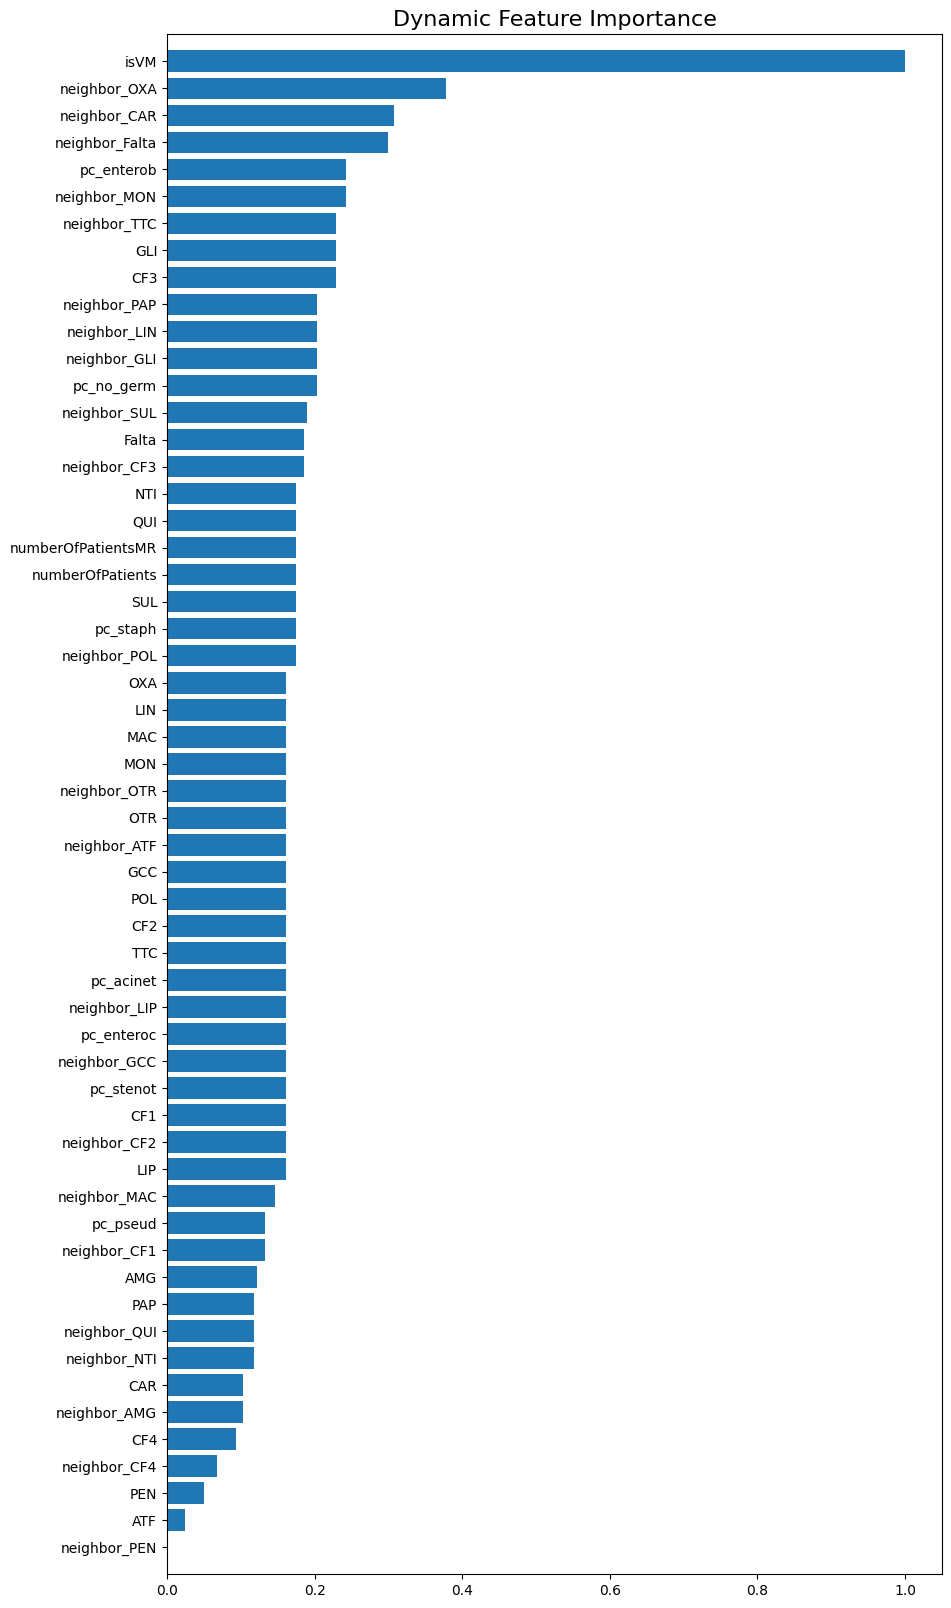

In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics
import torch

A = pd.read_csv("../../../experiments/MDR/considering_all_features/GCNNs/step2_graphRepresentation/"+way_to_build_graph+"/"+"s1/graph_Xtr_th_0.975.csv")
A = torch.tensor(np.array(A), dtype=torch.float32)

s1 = torch.load('../../../experiments/MDR/considering_all_features/GCNNs/step3_GCNNs/Exp3_dtw-hgd/saved_models/s1.pth')
s1.eval()


# Initialize variables
n = 4
seed = 42
results_perm_dyn = []

carp = str(1)
norm = "robustNorm"
# Load data and perform feature permutation
for i in [0]:
    # Load data
    X_train, X_val, X_test, y_train, y_val, y_test = load_data(norm, device, carp, SG=True)
    
    # Make predictions with the model
    with torch.no_grad():
        pred_probs, importances_pre_fc, weights_fc, pre_sigmoid, filters = s1(X_val)
                        
        pred = torch.round(pred_probs).view(-1) 

    # Calculate baseline ROC AUC score
    roc_baseline = sklearn.metrics.roc_auc_score(y_val.cpu().numpy(), pred.cpu().numpy())
    results_perm_dyn = []

    # Feature permutation
    for k in range(X_val.shape[1]):  # Assuming X_val has shape (samples, time_steps, features)
        # Shuffle feature K
        save_col = X_val[:, k, :].clone()
        X_val[:, k, :] = permutation_time_series(X_val, k, params, seed=seed)

        # Convert shuffled data to tensor

        # Compute ROC with feature K shuffled
        with torch.no_grad():
            pred_probs, importances_pre_fc, weights_fc, pre_sigmoid, filters = s1(X_val)
            pred = torch.round(pred_probs).view(-1) 
            
        roc = sklearn.metrics.roc_auc_score(y_val.cpu().numpy(), pred.cpu().numpy())
        results_perm_dyn.append(roc_baseline - roc)

        # Restore the original feature
        X_val[:, k, :] = save_col

    # Store results in a DataFrame
    if i == 0:
        df = pd.DataFrame()
    df["roc_seed_" + str(i)] = results_perm_dyn
    df["features_dyn"] = features
    df = df.set_index("features_dyn")

# Plot feature importance
split_directory = './Results_GNN'
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
normalized_importance = scaler.fit_transform(df.mean(axis=1).sort_values().values.reshape(-1, 1)).flatten()

plt.figure(figsize=(10, 20))
plt.barh(np.arange(len(features)), normalized_importance)
plt.yticks(np.arange(len(features)), df.mean(axis=1).sort_values().index.values)
plt.title('Dynamic Feature Importance',size=16)
plt.ylim((-1,len(features)))
output_path = os.path.join(split_directory, "dynamic_feature_importance.pdf")
plt.savefig(output_path, format='pdf', bbox_inches='tight')
plt.show()
print()

In [9]:
df["mean_importance"] = df.mean(axis=1)

df.to_csv('./Results_GNN/PFI_GNN.csv')

top_features_dyn = df["mean_importance"].nlargest(5).index.tolist()
print("5 best features:", top_features_dyn)

dynamic = pd.DataFrame(top_features_dyn, columns=['Selected Feature'])

dynamic.to_csv('../Results/GNN_selected_features.csv', index=False)

5 best features: ['isVM', 'neighbor_OXA', 'neighbor_CAR', 'neighbor_Falta', 'pc_enterob']
